In [1]:
import os
import time

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks, optimizers

from lib.data_normalizer import draw_image_with_boxes

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

IMAGE_SHAPE = (227,227)


2022-11-16 15:23:18.333476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 15:23:19.970168: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2022-11-16 15:23:19.970256: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-11-16 15:23:19.972802: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-11-16 15:23:20.166692: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


## Modelo de identificación de placas

In [2]:
# model = models.Sequential([

# #   Convolution layers
#     layers.Conv2D(64, (8, 8), activation='relu', padding="same", input_shape=(256, 256, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(32, (5, 5), activation='relu', padding="same"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(16, (3, 3), activation='relu', padding="same"),

# #   Normal layers
#     layers.Flatten(),
#     layers.Dense(256,activation='relu'),
#     layers.Dropout(0.2), # Evita la conexión total entre capaz para evitar overfitting
#     layers.Dense(128,activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(64,activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(4,activation='softmax'),   # 5 neuronas de salida, desempeño + fronteras
# ])

model = models.Sequential([
    #   Convolution layers
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu',
                  input_shape=(IMAGE_SHAPE[0],IMAGE_SHAPE[1],3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),

    #   Normal layers
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')
])



model.summary()

model.compile(optimizer=optimizers.SGD(lr=0.00005),
              loss="mean_squared_error",
              metrics=['accuracy'])



2022-11-16 15:23:29.150762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 15:23:29.152037: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6650 XT)
2022-11-16 15:23:29.224775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 15:23:29.224807: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-11-16 15:23:29.224826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/home/camilo/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Carga de Datos

In [3]:

# Load csv
plates_data = pd.read_csv("./normalized_data/unique_plates.csv")

# Take a sample of the data
number_of_samples = 400;
plates_data_sample = plates_data.sample(number_of_samples)

# Create arrays with inputs and outputs
plates_data_in = np.ndarray(shape=(number_of_samples, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
plates_data_out = np.array([plates_data_sample['xmin'],
                            plates_data_sample['ymin'],
                            plates_data_sample['xmax'],
                            plates_data_sample['ymax']]).T


# Load images from paths in csv

for i, path in enumerate(plates_data_sample['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels to RGB instead of BGR

# Normalize inputs
for i in range(len(plates_data_out)):
    # plates_data_out[i][0] = plates_data_out[i][0] / 100           # tag
    plates_data_out[i][0] = plates_data_out[i][0] / IMAGE_SHAPE[0]  # xmin
    plates_data_out[i][1] = plates_data_out[i][1] / IMAGE_SHAPE[1]  # ymin
    plates_data_out[i][2] = plates_data_out[i][2] / IMAGE_SHAPE[0]  # xmax
    plates_data_out[i][3] = plates_data_out[i][3] / IMAGE_SHAPE[1]  # ymax


# print first column of plates_data_sample
#plt.imshow(plates_data_in[i])
#plt.show()

## Test de datos

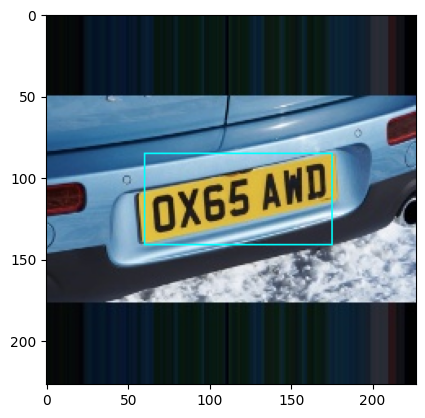

In [4]:
i = 99
# Scale predicted data
predicted_data = [[0.0,0.0,0.0,0.0,0.0]]
predicted_data[0][1] = plates_data_out[i][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][2] = plates_data_out[i][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][3] = plates_data_out[i][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][4] = plates_data_out[i][3] * IMAGE_SHAPE[1]  # ymax


draw_image_with_boxes(plates_data_in[i], predicted_data, border = 1)


## Entrenamiento

In [30]:
# Tensorboard configuration

root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = callbacks.TensorBoard(run_logdir)



model.fit(plates_data_in, plates_data_out, validation_split=0.2, epochs=20, batch_size = 1,
          callbacks=[tensorboard_cb])

model.save('models/model.h5')

Epoch 1/20


2022-11-09 20:50:02.226001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.4969

2022-11-09 20:50:42.320651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - 42s 129ms/step - loss: 0.1785 - accuracy: 0.4969 - val_loss: 0.1100 - val_accuracy: 0.4500
Epoch 2/20
320/320 [==============================] - 42s 131ms/step - loss: 0.1832 - accuracy: 0.4406 - val_loss: 0.1016 - val_accuracy: 0.4500
Epoch 3/20
320/320 [==============================] - 42s 131ms/step - loss: 0.1804 - accuracy: 0.5000 - val_loss: 0.1030 - val_accuracy: 0.5250
Epoch 4/20
320/320 [==============================] - 41s 130ms/step - loss: 0.1709 - accuracy: 0.4563 - val_loss: 0.1036 - val_accuracy: 0.5250
Epoch 5/20
320/320 [==============================] - 41s 129ms/step - loss: 0.1655 - accuracy: 0.5188 - val_loss: 0.0998 - val_accuracy: 0.4625
Epoch 6/20
320/320 [==============================] - 41s 129ms/step - loss: 0.1699 - accuracy: 0.4906 - val_loss: 0.0925 - val_accuracy: 0.5000
Epoch 7/20
320/320 [==============================] - 41s 129ms/step - loss: 0.1809 - accuracy: 0.4625 - val_loss: 0.0995 - val_accuracy: 0.4

## Usar modelo

(1, 227, 227, 3)
1/1 [==============================] - 0s 86ms/step
Salida: [[ 34.451  38.14  211.888 156.502]]


2022-11-09 20:48:52.086379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


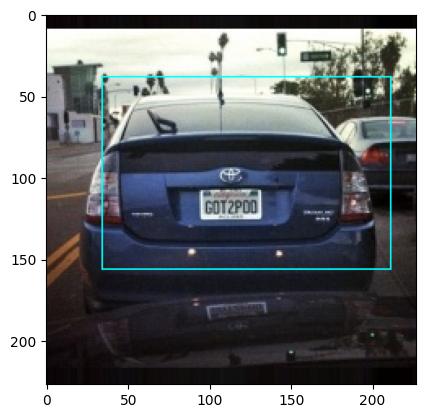

In [29]:
model = models.load_model("./models/model.h5")

test_image = np.ndarray(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
test_image[0] = cv2.cvtColor(cv2.imread("./normalized_data/plates_images/200.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
print(test_image.shape)
predicted_data = model.predict(test_image)

# Scale predicted data
predicted_data[0][0] = predicted_data[0][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][1] = predicted_data[0][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][2] = predicted_data[0][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][3] = predicted_data[0][3] * IMAGE_SHAPE[1]  # ymax

printable_data = [[0, predicted_data[0][0], predicted_data[0][1], predicted_data[0][2], predicted_data[0][3]]]

# predicted_data[0][1] = 10  # xmin
# predicted_data[0][2] = 10  # ymin
# predicted_data[0][3] = 100  # xmax
# predicted_data[0][4] = 100  # ymax

print("Salida: " + str(predicted_data))
draw_image_with_boxes(test_image[0], printable_data, border = 1)

In [25]:
print(model.input_shape)

(None, 227, 227, 3)
